In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import PIL, os
from PIL import Image, ImageDraw, ImageFont
import pytesseract
from pytesseract import image_to_string
from statistics import mean
from resizeimage import resizeimage
import torch
import torch.nn as nn
from torchvision.transforms import transforms
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import requests
from io import open
import math
import torchvision.models as models
import cv2

In [3]:
def load_model(model_path, model_arch, device='cpu'):
    
    params = torch.load(model_path, map_location= device)
    model_arch.load_state_dict(params)
    model_arch.to(device)
    model_arch.eval()
    return (model_arch)

    
def predict_litho(sub_row):
    
    if model == inception3_model:
        transformation = transforms.Compose([transforms.Resize(239),
                                            transforms.Pad(30),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.5041, 0.4542, 0.4337], [0.1791, 0.1726, 0.1621])])
    else:
        transformation = transforms.Compose([transforms.Resize(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.5041, 0.4542, 0.4337], [0.1791, 0.1726, 0.1621])])
 
    w_cm = sub_row.shape[1] * input_size* 0.1 / pixels_eq_mm  # convert to cm 
    new_w_cm = math.floor(w_cm)   # round to the smallest integer
    new_w = int(new_w_cm * pixels_eq_mm / (input_size* 0.1)) # get it in pixels
    r = int((sub_row.shape[1]-new_w)/2)
    step_pxl = int(pixels_eq_mm / 2)  # 1 cm in pixels
    probs_list = []
    
    for k in range(r, (new_w - pixels_eq_mm), step_pxl):
        window = sub_row[0:sub_row.shape[0], k:k+pixels_eq_mm]
        window = Image.fromarray(window)
        image_tensor = transformation(window).float()
        image_tensor = image_tensor.unsqueeze_(0)
        input = Variable(image_tensor).to(device)
        output = model(input)
        m = nn.Softmax(dim=1)
        probs = m(output)        
        probs_list.append(probs)
    output_total = torch.mean((torch.cat((probs_list),0)), 0)
    max_value, max_index = torch.max(output_total,0) 
    litho = list(class_to_idx_litho.keys())[list(class_to_idx_litho.values()).index(max_index.item())]
    output_total.cpu().detach().numpy()
    output_total = output_total.reshape(1, 4)
    torch.cuda.empty_cache()
    return(litho, output_total.cpu().detach().numpy())


def main_extract(img):
    '''
    :param img: tray image
    :return: core tray without the background, depths area, scale area, top text which include the last depth
    '''
    ht, wt, dt = img.shape
    # convert to gray scale to threshold
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    th, threshed = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)
    # de-noising using image morphology
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    morphed = cv2.morphologyEx(threshed, cv2.MORPH_CLOSE, kernel)
    # finding the biggest contour which includes the core tray rectangle
    cnts, _ = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt = sorted(cnts, key=cv2.contourArea)[-1]
    x, y, w, h = cv2.boundingRect(cnt)
    # extract core tray from the original image using the obtained coordinates
    extracted = img[y:y + h, x:x + w]
    # extract depths region located on the left side of the tray
    script_vert = img[y:y + h, 0:x]
    # extract scale region below the core tray
    shift_up = int(math.sqrt((x - x) ** 2 + (ht - (y + h)) ** 2) / 2)
    script_h = img[y + h - shift_up:ht - shift_up, x:x + w]
    #extract the top text region to get the final depth
    script_L_D = img[0:y, x:w]
    # optional for plotting r1 and r2 for later to show the results on the raw image, next to 'final' function
    r1 = x
    r2 = y
    return (extracted, script_vert, script_h, script_L_D, r1, r2)

def get_depth(script_vert, script_L_D):
    '''
    :param script_vert: the image region that includes depths of each core row, as displaced on the right side of the image
    :param script_L_D: the image region that includes the last depth of the core tray, needed to calculate core length of
                    the last core row
    :return: a list of all depths
    '''
    # center the script in the middle of the image, currently it is too close to the bottom edge
    script_vert = script_vert[0:script_vert.shape[0], int(0.5 * script_vert.shape[1]): script_vert.shape[1]]
    depths0 = Image.fromarray(script_vert)
    depths0 = depths0.transpose(PIL.Image.ROTATE_270)
    new = Image.new(mode=depths0.mode, size=(depths0.width, 2 * depths0.height), color='white')
    new.paste(depths0)
    #downsample the whole image showed more accurate results
    depths1 = new.resize((int(0.3 * new.width), int(0.3 * new.height)))
    #use pytesseract to detect text, and some post processing to separate and clean the detected depths
    depths = image_to_string(depths1, config='-c tessedit_char_whitelist=.0123456789m')
    depths = depths.replace('m', ' ')
    depths = depths.split(' ')
    depths_list = [d for d in depths if isdigit(d) == True]
    # similarly, get the last depth of the tray from the top text, and add it to other depths
    last_depth = Image.fromarray(script_L_D)
    last_depth = image_to_string(script_L_D, config='-c tessedit_char_whitelist=to.0123456789m')
    last_depth = last_depth.split('to')[-1]
    last_depth = last_depth.split('m')[0]
    depths_list.append(last_depth)
    depths_list = sorted(depths_list, key=float)
    return (depths_list)  

def isdigit(d):
    try:
        float(d)
        return True
    except ValueError:
        return False

def get_scales(script_h):
    gray = cv2.cvtColor(script_h, cv2.COLOR_BGR2GRAY)                        
    th, threshed = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY_INV)

    #keep only the horizontal line only to detect it in the next step
    kern = np.ones((1,int(0.5 * script_h.shape[1])),np.uint8)        
    opening = cv2.morphologyEx(threshed, cv2.MORPH_OPEN, kern)

    #detect the horizontal line
    minLineLength =  int(0.8 * script_h.shape[1])
    maxLineGap = 0
    lines = cv2.HoughLinesP(opening,1,np.pi/180 ,minLineLength, minLineLength, maxLineGap)

    y_list = sorted([lines[i, 0, 1] for i in range (len(lines))], key = int, reverse=True)
    y = y_list[0]  # this the lowest line (max y) as reverse is true in the sorting of Ys
    scale_image = threshed[y:y+int(script_h.shape[0]/3), 0:script_h.shape[1]]

    #detect vertival lines_ first keep vertical lines only using erosion and dilation        
    kern = np.ones((int(0.5 * scale_image.shape[0]),1),np.uint8)        
    eroded = cv2.erode(scale_image, kern, iterations = 2)

    kernd = np.ones((scale_image.shape[0],1),np.uint8)        
    dilated = cv2.dilate(eroded, kernd, iterations = 2)

    # detect the lines to get their coordinates and measure the distance in pixles
    minLineLength =  int(0.5 * dilated.shape[0])
    maxLineGap = 2
    lines_v = cv2.HoughLinesP(dilated, 1, np.pi/180, minLineLength, minLineLength, maxLineGap)

    # now, measure the distance in pixels  (between the first two lines)
    line_list = sorted([lines_v[i, 0, 0] for i in range (len(lines_v))], key = int)  # because they are not sorted in the lines array
    distance_pixels = line_list[1] - line_list[0]

    # to get the measurments in texts from the image, crop the image and focus on the measurments part
    scale1 = threshed[y:y+int(threshed.shape[0]), 0:script_h.shape[1]] 

    #apply morpphology to get rid of the lines as may be interpredted as '1' especislly vertical lines
    kernel = np.ones((3,3),np.uint8)    
    scale2 = cv2.morphologyEx(scale1, cv2.MORPH_OPEN, kernel)
    scale2 = cv2.bitwise_not(scale2)  # the image is inversed threshold, inverse it here to have white background and black text 
    scale_img =Image.fromarray(scale2)
    scale_list = image_to_string(scale_img, lang = 'eng', config='--psm 7 -c tessedit_char_whitelist=0123456789')
    scale_list= scale_list.split(' ')
    scale_list = sorted(scale_list, key = int)
    # find distance in mm
    distance_mm = int(scale_list[3])- int(scale_list[2])     #changed to fix IHAD1
    # find the scale to convert from pixels to mm
    pixels_eq_mm = int(20 * distance_pixels/distance_mm)     #this is the used imge size of (2 x 2) cm 

    return(int(pixels_eq_mm))


def litho_log(extracted, depths_list, pixels_eq_mm, model):
    '''this function is used to print the lithology prediction along the core, for every 1 cm.
    to get the lithology only (before and after the smoothing function), see "smoothing predictions.ipynb" instead.
    '''
    step = int(pixels_eq_mm/2)
    no_rows = len(depths_list)
    row_h = int(extracted.shape[0]/no_rows)
    row_w = extracted.shape[1]
    new_h = no_rows * row_w
    new_w = 3 * row_h 
    new =   Image.new('RGB', (new_w, new_h), 'white')
    probs_1cm = np.zeros((1,4))
    depths_1cm = np.zeros(1)
    
    i = 0
    for y in range(0,extracted.shape[0],row_h):     
        print('row {} of {}'.format(i+1, no_rows))
        #r = int((row_h - 0.8 * row_h)/2)
        row = extracted[y:y+row_h, 0:extracted.shape[1]]    # of hight (h)   # analyse and redict here
        row =Image.fromarray(row)
        row = row.transpose(PIL.Image.ROTATE_270)
        row_y = i* row_w
        row_depth = float(depths_list[i])
        new.paste(row, box =(0, row_y, row_h, row_y+row_w))   #(x1, y1, x2, y2)
        row = np.asarray(row) 
        #to print a depth column
        depth = float(depths_list[i])
        
        k = 0
        for j in range (0, row.shape[0]-pixels_eq_mm, step):  # 1cm step in pixels
            torch.cuda.empty_cache()
            v = k * step # this will be (0, 1, 2, ...cm as step is 1cm in pixels)
            sub_row = row[v:v+pixels_eq_mm, 0:row.shape[1]]
            #sub_row = Image.fromarray(sub_row)
            #sub_row.save('C:/Users/mutris-GPU/Desktop/fatimah/lithology/try4/log/sub/{}_{}.jpeg'.format(i,j))
            litho, probs = predict_litho(sub_row)
            #probs.to(device2)
            #litho = 'litho'
            if litho != 'ignore':
                
                #write the predicted lithology at each depth, write depths as well
                font = ImageFont.truetype('arial.ttf', 100)  # or smaller font size
                draw = ImageDraw.Draw(new)
                text_x = int(2 * row.shape[1]) # to have a small gap between the core column and the text
                text_y = int(row_y+ v+ step)
                draw.text((text_x, text_y), litho , font=font, fill='black') # is subrow y plus half step'

                #print depths at every 1 cm, excluding 'ignore' 
                text_x_d = int(1.2* row.shape[1]) # to have a small gap between the core column and the text
                draw.text((text_x_d, text_y), str(depth)+' m' , font=font, fill='black') # is subrow y plus half step'
                probs_1cm = np.append(probs_1cm, probs, axis =0)
                depth =round(depth + 0.01, 2)
                depths_1cm = np.append(depths_1cm, depth)
            k +=1
        i+=1
        if i == no_rows: break
    probs_1cm = np.delete(probs_1cm, 0, axis = 0)
    depths_1cm = np.delete(depths_1cm, 0)
    
    return(new, probs_1cm, depths_1cm)


print("done")

done


In [4]:
device = 'cpu'
class_to_idx_litho =  {'ignore': 0, 'l.s': 1, 's.s': 2, 'shale': 3}

def load_model(model_path, model_arch, device):
    params = torch.load(model_path, map_location= device)
    model_arch.load_state_dict(params)
    model_arch.to(device)
    model_arch.eval()
    return (model_arch)

#load 'RN18_model'
RN18_path = './pretrained models/ResNet18.pt'
RN18 = models.resnet18(pretrained=False)
RN18.fc = nn.Linear(512, 4)
RN18_model = load_model(RN18_path, RN18, device)

#load 'RNx50_model'
RNx50_path = './pretrained models/ResNeXt50.pt'
RNx50 = models.resnext50_32x4d(pretrained=False)
RNx50.fc = nn.Linear(2048, 4)
RNx50_model = load_model(RNx50_path, RNx50, device)

#load 'inception3_model
inception3_model = torch.load('./pretrained models/Inception_v3.pt', map_location= torch.device('cpu'))
inception3_model.eval()
inception3_model.aux_logits=False
inception3_model.to(device)

C:\Users\z5029775\AppData\Local\Continuum\anaconda3\envs\fatimah\lib\site-packages\torch\serialization.py:657: SourceChangeWarning: source code of class 'torchvision.models.inception.Inception3' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\z5029775\AppData\Local\Continuum\anaconda3\envs\fatimah\lib\site-packages\torch\serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\z5029775\AppData\Local\Continuum\anaconda3\envs\fatimah\lib\site-packages\torch\serialization.py:657: SourceChangeWarning: source code of class 'torch

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

processing image: test_image2
row 1 of 6
row 2 of 6
row 3 of 6
row 4 of 6
row 5 of 6
row 6 of 6
Processing time for one image is: 3m 22s


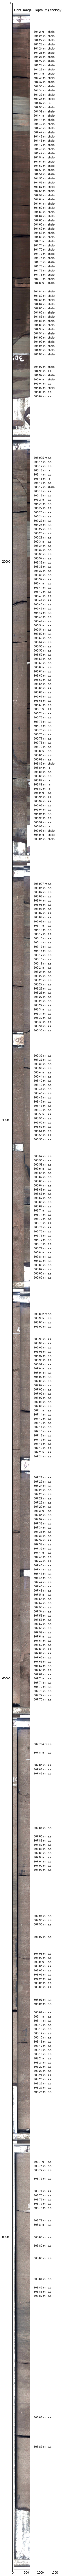

In [5]:
import time

input_path ='./data/test_image2.jpg'

model = RNx50
input_size = 20

for file in glob.glob(input_path):
    since =time.time()
    image = cv2.imread(file)
    img= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_name, ext = os.path.splitext(os.path.basename(file))
    print('processing image:', image_name)
    extracted, script_vert, script_h, script_L_D, _, _=  main_extract(img) 
    depths_list = get_depth(script_vert, script_L_D)
    pixels_eq_mm = get_scales(script_h)
    pics = []
    log_image, probs_1cm, depths_1cm = litho_log(extracted, depths_list, pixels_eq_mm, model)
    d  = depths_1cm.reshape(-1, 1)
    all_ = np.append(probs_1cm, d,  axis =1)
    #np.savetxt('C:/Users/mutris-GPU/Desktop/fatimah/lithology/try4/log/results/inception/{}.csv'.format(image_name), all_)
    #to add heading
    w, h = log_image.size
    header = int(0.2 *w)
    image_with_header = Image.new('RGB', (w , header+h), 'white')
    image_with_header.paste(log_image, box =(0, header, w, header+h))   #(x1, y1, x2, y2)
    font = ImageFont.truetype('arial.ttf', 120)  # or smaller font size
    draw = ImageDraw.Draw(image_with_header)
    draw.text((int(0.03 * w), int(0.5 * header)), 'Core image' , font=font, fill='black') # core
    draw.text((int(1.2 * w/3), int(0.5 * header)), 'Depth (m)' , font=font, fill='black') # depth
    draw.text((int(2*w/3), int(0.5 * header)), 'Lithology' , font=font, fill='black') # litho
    plt.figure(1, figsize = (20,175))
    plt.imshow(image_with_header)
    plt.savefig('./data/{}.tiff'.format(image_name+'_results'), dpi=200)
    last = time.time()- since
    print('Processing time for one image is: {:.0f}m {:.0f}s'.format(last // 60, last % 60))

# using a smoothing function

In [6]:
def get_points(points):
    avg = np.mean(points)
    max_ = np.max(points)
    min_ = np.min(points)
    if (max_ - avg) < (avg - min_): add_points = max_
    else:add_points = min_
    return(add_points)

def smooth(data, window, trials):
    input_data =data
    for k in range (1, trials+1):
        smoothed=[]
        step =window-1
        for i in range(0, len(input_data) - window +2, step):
            points_in=input_data[i:i+window]
            add_points =get_points(points_in)
            for j in range (step): smoothed.append(add_points)
        if len(smoothed) < len(input_data):
            #print('cond')
            last = len(input_data)-len(smoothed)
            points_in=input_data[(i+window-1):(i+window-1)+last]
            add_points = get_points(points_in)
            for j in range (last): smoothed.append(add_points)
        window += k
        input_data =smoothed
    return np.array(smoothed)


def smooth_std(a, w):
    c = np.copy(a)
    #add half the window size to the beinig and the end f the array, so the middle item in the window is processed 
    add_n = math.floor(w/2)
    add_1 = a[0:add_n]
    add_2 = a[len(a)-add_n:len(a)]
    b = np.concatenate((add_1, a, add_2), axis=0)
    for i in range (add_n, len(b)-add_n):
        window = b[i-add_n: i+add_n+1]
        s = np.std(window)
        m = np.mean(window)
        if b[i] < (m-s) or b[i] > (m+s): c[i-add_n] = m
    return(c)

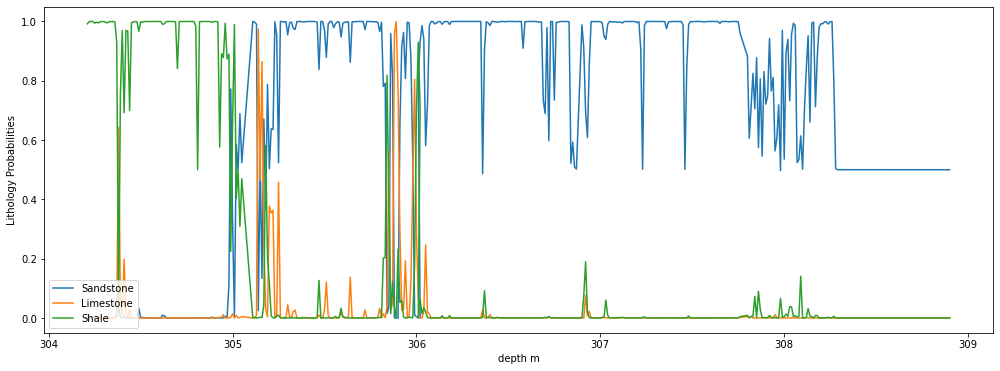

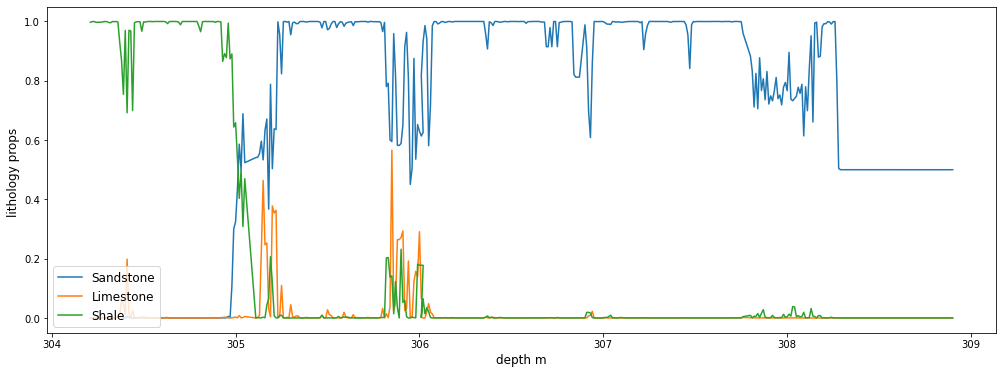

In [8]:
depths = all_[:, 4]
sandstone =  all_[:, 2]
limestone = all_[:, 1]
shale = all_[:, 3]

#smooth prediction
w = 15 # window size for smoothing 15 cm
smoothed_sandstone = smooth_std(sandstone, w)
smoothed_limestone = smooth_std(limestone, w)
smoothed_shale = smooth_std(shale, w)

plt.figure(1, figsize =(17,6))

plt.plot(depths, sandstone , label = 'Sandstone')
plt.plot(depths, limestone , label = 'Limestone')
plt.plot(depths, shale , label = 'Shale')
plt.xlabel('depth m')
plt.ylabel('Lithology Probabilities')
plt.legend(loc = 3)
plt.savefig('./data/{}.png'.format(image_name+'_smoothed_results'), dpi=200)


plt.figure(3, figsize =(17,6))

plt.plot(depths,smoothed_sandstone, label = 'Sandstone')
plt.plot(depths,smoothed_limestone, label = 'Limestone')
plt.plot(depths,smoothed_shale , label = 'Shale')

plt.xlabel('depth m', fontsize = 12)
plt.ylabel('lithology props ', fontsize = 12)
plt.legend(loc ='lower left', fontsize = 12)

plt.show()
